# Medicinal Plant Classification

### Import all the Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Medicinal_Plant_Dataset_(Augmented)",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 14380 files belonging to 30 classes.


In [8]:
class_names = dataset.class_names
class_names

['Arive-Dantu',
 'Basale',
 'Betel',
 'Crape_Jasmine',
 'Curry',
 'Drumstick',
 'Fenugreek',
 'Guava',
 'Hibiscus',
 'Indian_Beech',
 'Indian_Mustard',
 'Jackfruit',
 'Jamaica_Cherry-Gasagase',
 'Jamun',
 'Jasmine',
 'Karanda',
 'Lemon',
 'Mango',
 'Mexican_Mint',
 'Mint',
 'Neem',
 'Oleander',
 'Parijata',
 'Peepal',
 'Pomegranate',
 'Rasna',
 'Rose_apple',
 'Roxburgh_fig',
 'Sandalwood',
 'Tulsi']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[26  2 22  3  0  8  7  2 27 11 27  4 23 17 20 28 28  4 13  6 16 23 19 27
  4  5 14 27 25 25 26 14]


As we can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

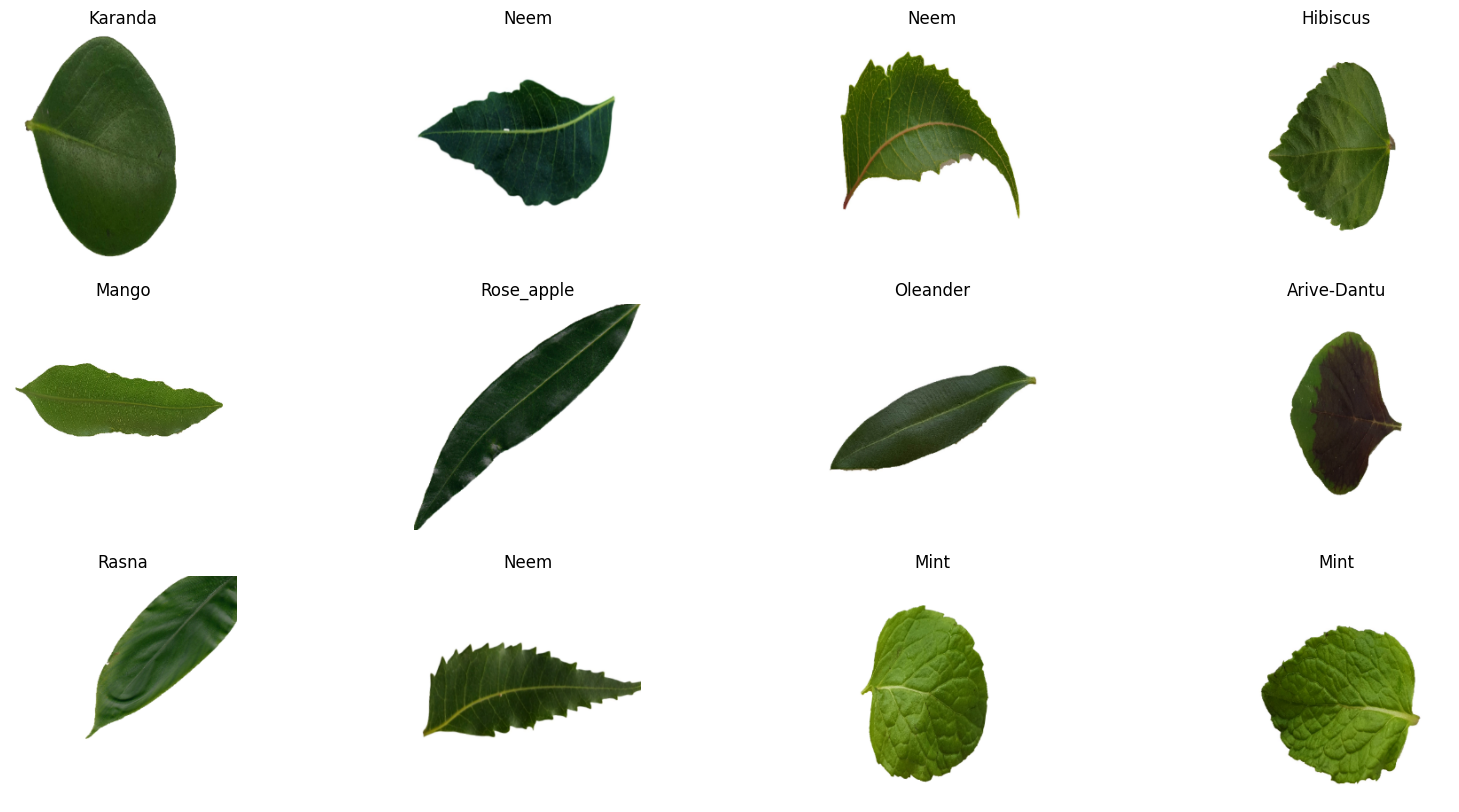

In [10]:
plt.figure(figsize=(20, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

450

In [10]:
train_size = 0.8
len(dataset)*train_size

360.0

In [11]:
train_ds = dataset.take(360)
len(train_ds)

360

In [12]:
test_ds = dataset.skip(360)
len(test_ds)

90

In [13]:
val_size=0.1
len(dataset)*val_size

45.0

In [14]:
val_ds = test_ds.take(45)
len(val_ds)

45

In [15]:
test_ds = test_ds.skip(45)
len(test_ds)

45

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

360

In [19]:
len(val_ds)

45

In [20]:
len(test_ds)

45

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
# data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2),
# ])

#### Applying Data Augmentation to Train Dataset

In [24]:
# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN**

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 30

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)
model.save("../leaf_1.h5")

Epoch 1/25
360/360 [==============================] - 322s 870ms/step - loss: 2.2275 - accuracy: 0.3428 - val_loss: 1.2552 - val_accuracy: 0.6125
Epoch 2/25
360/360 [==============================] - 290s 804ms/step - loss: 0.8869 - accuracy: 0.7265 - val_loss: 0.5291 - val_accuracy: 0.8236
Epoch 3/25
360/360 [==============================] - 280s 777ms/step - loss: 0.4433 - accuracy: 0.8580 - val_loss: 0.3111 - val_accuracy: 0.9021
Epoch 4/25
360/360 [==============================] - 281s 781ms/step - loss: 0.2885 - accuracy: 0.9070 - val_loss: 0.2499 - val_accuracy: 0.9153
Epoch 5/25
360/360 [==============================] - 280s 779ms/step - loss: 0.1949 - accuracy: 0.9365 - val_loss: 0.2066 - val_accuracy: 0.9306
Epoch 6/25
360/360 [==============================] - 280s 778ms/step - loss: 0.1712 - accuracy: 0.9435 - val_loss: 0.1159 - val_accuracy: 0.9653
Epoch 7/25
360/360 [==============================] - 280s 778ms/step - loss: 0.1270 - accuracy: 0.9573 - val_loss: 0.1096 -

In [31]:
scores = model.evaluate(test_ds)

45/45 [==============================] - 38s 171ms/step - loss: 0.0368 - accuracy: 0.9917


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [33]:
scores

[0.036790478974580765, 0.9916666746139526]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 360}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [37]:
type(history.history['loss'])

list

In [38]:
len(history.history['loss'])

25

In [39]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.2274978160858154,
 0.8869280815124512,
 0.44333896040916443,
 0.28846296668052673,
 0.19494619965553284]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [41]:
len(acc)

25

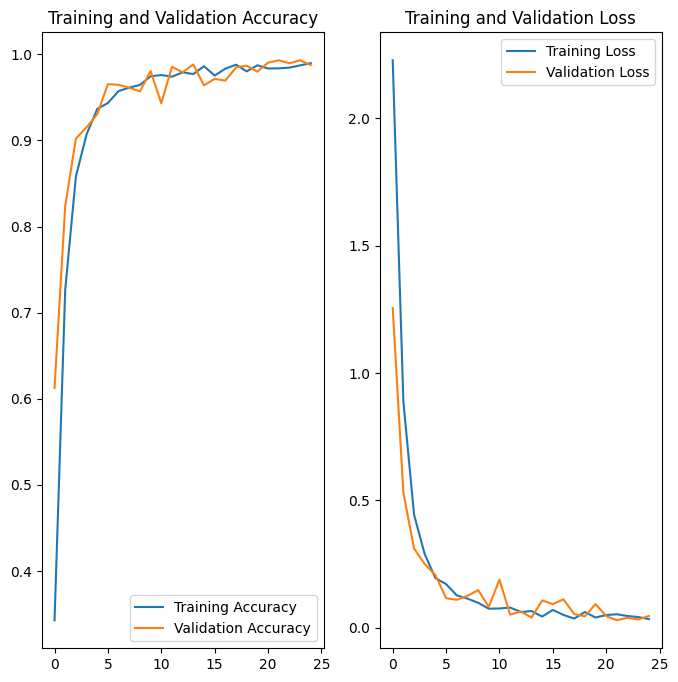

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Mexican_Mint
predicted label: Mexican_Mint


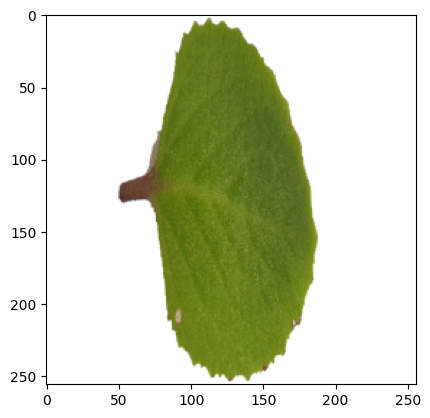

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

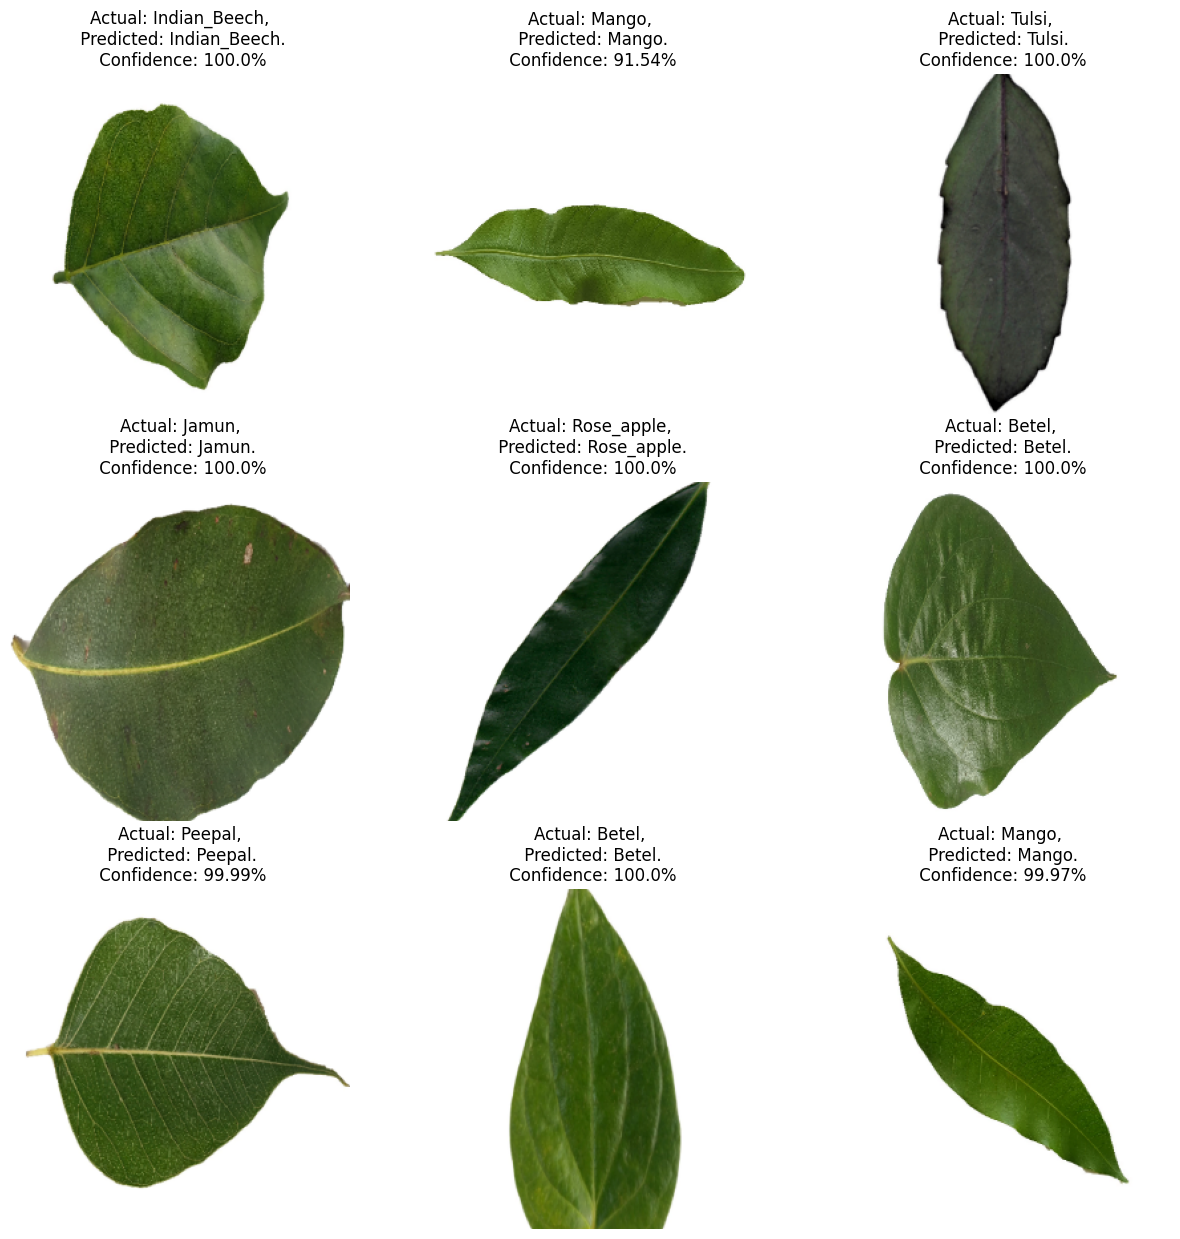

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")